In [1]:
import numpy as np
import os
import glob
import allantools
import matplotlib.pyplot as plt
from tqdm import tqdm

import counts_statistics_qpe as cs
import phase_estimation_functions as qpe
from densitymatrix import DM

In [2]:
"""
DEINING FOLDERS AND DIRECTORIES
"""
data_dir = r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Bell\long_QPE_no_Certification"
os.chdir(data_dir)
filenames = [i for i in glob.glob("COMPLETE*")]
n_qubits = 4

stabilizers = ["xxxx"]
stab_sign = [1]

final_p_fail_mean_bottom = [0.0114, 0.0116, 0.0259]
final_p_fail_mean_top = [0.0074, 0.0079, 0.0173]

input_state = "Bell" # or GHZ # This will specify in which folder we want to save the figures

In [3]:
"""
CALCULATING THE STATISTICS OBTAINED FROM THE XXXX MEASUREMENTS
"""
n_rounds = 3000
samples_evolution = np.arange(1, n_rounds+1, 1)
stats_list = {"file_1":{}, "file_2":{}, "file_3":{}}

p_pass = np.zeros((2, len(filenames), n_rounds))
p_pass_error = np.zeros((2, len(filenames), n_rounds))

for index, file in enumerate(filenames):    
    # pair = 0 refers to top pair and pair = 1 refers to bottom pair
    for pair in range(2):
        STABILIZER_TO_INDEX = {stab: i for i, stab in enumerate(stabilizers)}
        file_dir = f"{data_dir}\{file}\counts"
        os.chdir(file_dir)

        files = [i for i in glob.glob("Phase*.txt")]
        ### This assumes the label is of the form: "PhaseEstimation=xxxx_{index}_{theta_4}"
        files.sort(key = lambda x: int((x.split("_")[2]).split(".")[0]))

        stats = cs.Operartors_Statistics(n_qubits, stabilizers, stab_sign, STABILIZER_TO_INDEX, files, file_dir, input_state, str(pair)) #Set_loops = 1?
        stats.shuffle_data()
        stats_list[f"file_{index+1}"][pair] = stats

        p_pass_list, n_samples_list = stats.get_pass_prob_evolution(samples_evolution)
        
        p_pass[pair][index] = np.array(p_pass_list, dtype = float)
        p_pass_error[pair][index] = np.array(stats.p_pass_error_list, dtype = float)
    
p_fail = 1 - p_pass
p_fail_error = p_pass_error

<string>:15: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<string>:15: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\c'
C:\Users\QILIP6\AppData\Local\Temp\ipykernel_41464\324127258.py:15: SyntaxWarning: invalid escape sequence '\{'
  file_dir = f"{data_dir}\{file}\counts"
C:\Users\QILIP6\AppData\Local\Temp\ipykernel_41464\324127258.py:15: SyntaxWarning: invalid escape sequence '\c'
  file_dir = f"{data_dir}\{file}\counts"


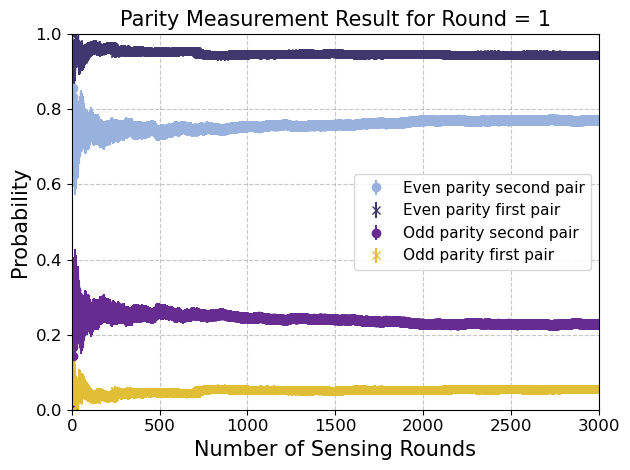

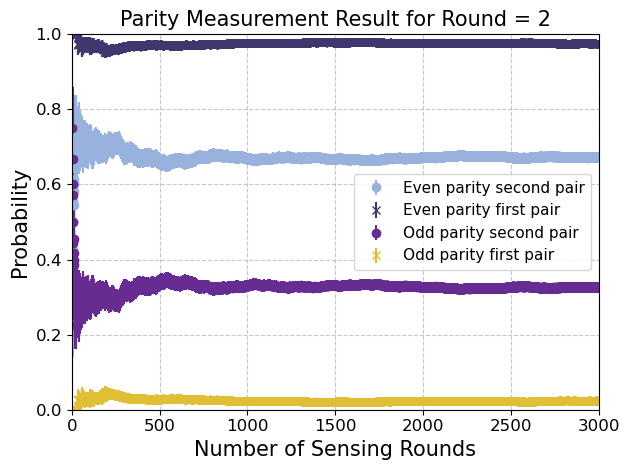

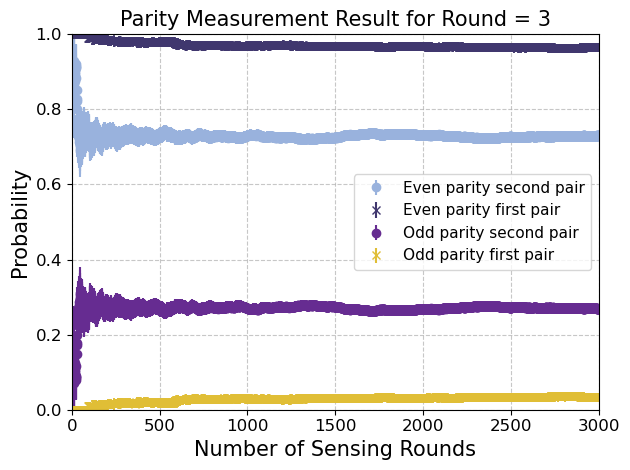

In [4]:
colors = ["#99B2DD","#662C91","#40376E","#E0BE36"]
for index, file in enumerate(filenames):
    plt.errorbar(samples_evolution, p_pass[0][index], p_pass_error[0][index], color=colors[0], fmt='o', label = "Even parity second pair")
    plt.errorbar(samples_evolution, p_pass[1][index], p_pass_error[1][index], color=colors[2], fmt='x', label = "Even parity first pair")
    plt.errorbar(samples_evolution, p_fail[0][index], p_fail_error[0][index], color=colors[1], fmt='o', label = "Odd parity second pair")
    plt.errorbar(samples_evolution, p_fail[1][index], p_fail_error[1][index], color=colors[3], fmt='x', label = "Odd parity first pair")
    plt.xlabel("Number of Sensing Rounds", fontsize=15)
    plt.ylabel("Probability", fontsize=15)
    plt.title(f"Parity Measurement Result for Round = {index+1}", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,1)
    plt.xlim(0,3000)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11, markerscale=1.)
    plt.tight_layout()
    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Bell\Long_QPE_no_Certification\Parity_Measurement_Graph\Long_sensing_p_evol_r={index+1}")
    plt.show()

In [27]:
"""
ESTIMATION OF THETA: WITH THE VISIBILITY AND DENSITY MATRIX METHODS
IT SAVES ALL THE RELEVANT PARAMS IN thetas_mle DICTIONARY
"""
mle = {}
thetas_mle = {0 :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                            "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}},
                    "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                            "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}}},
            1 :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                        "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}},
                "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                        "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}}}}

def generate_angles_in_radians(n):
    x = []
    """
    Génère 4 angles aléatoires en radians, chacun étant compris entre 0 et π/2,
    et dont la somme est exactement égale à π/2.
    """
    for i in range(n):
        target_sum = np.pi / 2  # Somme cible
        angles = np.sort(np.random.uniform(-np.pi/2, target_sum, 1))  # Générer 3 points de coupure aléatoires
        
        # Calculer les 4 angles en prenant les différences successives
        a1 = angles[0]
        a2 = target_sum - angles[0]  # Assurer que la somme soit bien égale à π/2

        x.append([a1, a2])
    return x

def set_estimation_params(estimator_class, dic, index, a_vectors_list,lim):
    mle = estimator_class
    estimation_results = mle.get_theta(get_cov = True, set_lim = lim).x

    dic["sum"]["values"][index] = np.array(np.sum(estimation_results))
    dic["sum"]["variance"][index] = np.array(mle.get_variance(np.array([1, 1])))
    dic["sum"]["fisher_info"][index] = np.array(mle.fisher_bound/n_rounds)
    for i in range(2):
        dic["indiv"]["values"][i][index] = (estimation_results[i])
        dic["indiv"]["variance"][i][index] = np.array(mle.get_variance(a_vectors_list[i]))
        dic["indiv"]["fisher_info"][i][index] = np.array(mle.fisher_bound/n_rounds)
    return dic

### Vector list to extract the estimation of the indifivual params
a_vectors_list = [np.array([1, 0]), np.array([0, 1])]
x0 = generate_angles_in_radians(30)

### Loading the density matrices
dm_folder = [i for i in glob.glob(r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Bell\QST\Long_QPE_no_Certification\Run*")]
QST_file = []
for index, file in enumerate(dm_folder):
    os.chdir(file)
    QST_file.append(glob.glob("QST_*")[0])

density_matrix = {k: {} for k in QST_file}
for index, file in enumerate(dm_folder):
    os.chdir(f'{file}\\{QST_file[index]}')
    with open('density_TOP.npy','rb') as f:
        density_matrix[str(QST_file[index])][0] = np.load(f)
    with open('density_BOTTOM.npy','rb') as g:
        density_matrix[str(QST_file[index])][1] = np.load(g)

bnds = ((0,np.pi/2),(0,np.pi/2))

for index, file in enumerate(filenames):
    v = np.array([1 - 2*final_p_fail_mean_top[index], 1 - 2*final_p_fail_mean_bottom[index]])
    for i in range(2):
        dm = density_matrix[str(QST_file[index])][i]
        meas_stats = stats_list[f"file_{index+1}"][i]
        ##### Theta estimation and saving params in dictionary #####
        mle[file] = qpe.Estimator(input_state, i, meas_stats, x0, bnds, "visibility", v[i])
        lim = 3001
        set_estimation_params(mle[file], thetas_mle[i]["v"], index, a_vectors_list,lim)
        mle[file].set_function_type("density_matrix", dm)
        set_estimation_params(mle[file], thetas_mle[i]["dm"], index, a_vectors_list,lim)

c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:210: RuntimeWarning: invalid value encountered in sqrt
  self.var = np.sqrt(var2)
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:210: RuntimeWarning: invalid value encountered in sqrt
  self.var = np.sqrt(var2)


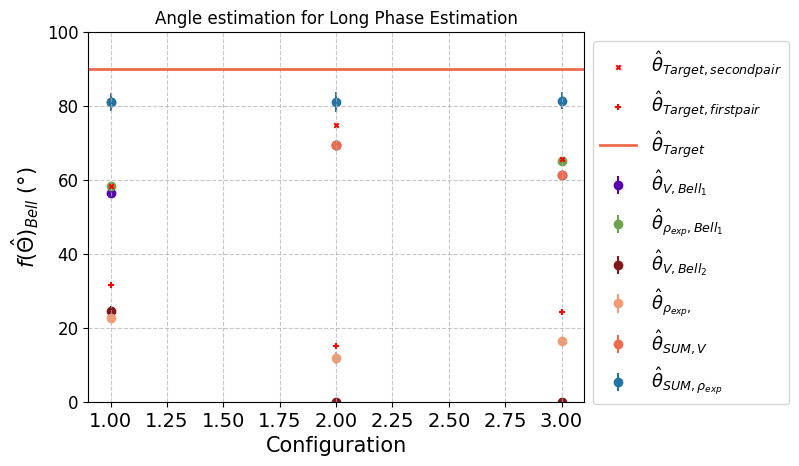

In [29]:
colors = ["#EE6C4D", "#5603AD", "#6DA34D", "#81171B", "#F19C79", "#2274A5"]
x_data = [1, 2, 3]

target_angles = {'RUN_1' : [np.pi/8,np.pi/5,np.pi/16,0.3534291735288517],
                 'RUN_2' : [np.pi/6,np.pi/4,np.pi/8,-0.13089969389957457],
                 'RUN_3' : [2*np.pi/9,np.pi/7,np.pi/8,0.03116659378]}

target_sums = {"top": [sum(target_angles['RUN_1'][:2])*180/np.pi,
                        sum(target_angles['RUN_2'][:2])*180/np.pi,
                        sum(target_angles['RUN_3'][:2])*180/np.pi],
               "bottom": [sum(target_angles['RUN_1'][-2:])*180/np.pi,
                        sum(target_angles['RUN_2'][-2:])*180/np.pi,
                        sum(target_angles['RUN_3'][-2:])*180/np.pi], 
                "total" :[sum(target_angles['RUN_1'])*180/np.pi,
                        sum(target_angles['RUN_2'])*180/np.pi,
                        sum(target_angles['RUN_3'])*180/np.pi]}

plt.figure(figsize=(6.4, 4.8))
plt.errorbar(x_data, thetas_mle[0]["v"]["sum"]["values"]*180/np.pi,thetas_mle[0]["v"]["sum"]["variance"]*180/np.pi, color=colors[1], label = r"$\hat{\theta}_{V,Bell_1}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[0]["dm"]["sum"]["values"]*180/np.pi,thetas_mle[0]["dm"]["sum"]["variance"]*180/np.pi, color=colors[2], label = r"$\hat{\theta}_{\rho_{exp},Bell_1}$", marker = 'o', linestyle = "",zorder=1)
plt.scatter(x_data, target_sums["top"], color='red', s=10, marker="x",label=r"$\hat{\theta}_{Target,second pair}$",zorder=2)

plt.errorbar(x_data, thetas_mle[1]["v"]["sum"]["values"]*180/np.pi,thetas_mle[1]["v"]["sum"]["variance"]*180/np.pi, color=colors[3], label = r"$\hat{\theta}_{V,Bell_2}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[1]["dm"]["sum"]["values"]*180/np.pi,thetas_mle[1]["dm"]["sum"]["variance"]*180/np.pi, color=colors[4], label = r"$\hat{\theta}_{\rho_{exp},}$", marker = 'o', linestyle = "",zorder=1)
plt.scatter(x_data, target_sums["bottom"], color='red', s=20, marker="+",label=r"$\hat{\theta}_{Target,first pair}$",zorder=2)

plt.errorbar(x_data, (thetas_mle[1]["v"]["sum"]["values"]+thetas_mle[0]["v"]["sum"]["values"])*180/np.pi,(thetas_mle[1]["v"]["sum"]["variance"]+thetas_mle[0]["v"]["sum"]["variance"])*180/np.pi, color=colors[0], label = r"$\hat{\theta}_{SUM,V}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, (thetas_mle[1]["dm"]["sum"]["values"]+thetas_mle[0]["dm"]["sum"]["values"])*180/np.pi,(thetas_mle[1]["dm"]["sum"]["variance"]+thetas_mle[0]["dm"]["sum"]["variance"])*180/np.pi, color=colors[5], label = r"$\hat{\theta}_{SUM,\rho_{exp}}$", marker = 'o', linestyle = "",zorder=1)
plt.axhline(np.pi/2*180/np.pi, color=colors[0], linestyle='-', label=r"$\hat{\theta}_{Target}$", linewidth=2)


plt.xlabel("Configuration", fontsize=15)
plt.ylabel(r"$f(\hat{\Theta})_{Bell}$ (°)", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
plt.ylim(0,100)
plt.legend(fontsize=13, markerscale=1.,loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Angle estimation for Long Phase Estimation")
plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Bell\Long_QPE_no_Certification\Angle_Long_Phase_Estimation.pdf", bbox_inches='tight')
plt.show()

In [ ]:
"""
GENERATING THE DATA FOR THE ALLAN DEVIATION
"""
def write_stats(contents, filelabels):
    for content, filelabel in zip(contents, filelabels):
        f = open(f"{writting_dir}\\{filelabel}.txt", "w")
        f.write(str(content))
        f.close()

def generate_angles_in_radians(n):
    x = []
    """
    Génère 4 angles aléatoires en radians, chacun étant compris entre 0 et π/2,
    et dont la somme est exactement égale à π/2.
    """
    for i in range(n):
        target_sum = np.pi / 2  # Somme cible
        angles = np.sort(np.random.uniform(-np.pi/2, target_sum, 1))  # Générer 3 points de coupure aléatoires
        
        # Calculer les 4 angles en prenant les différences successives
        a1 = angles[0]
        a2 = target_sum - angles[0]  # Assurer que la somme soit bien égale à π/2

        x.append([a1, a2])
    return x

dm_folder = [i for i in glob.glob(r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Bell\QST\Long_QPE_no_Certification\Run*")]
QST_file = []
for index, file in enumerate(dm_folder):
    os.chdir(file)
    QST_file.append(glob.glob("QST_*")[0])

density_matrix = {k: {} for k in QST_file}
for index, file in enumerate(dm_folder):
    os.chdir(f'{file}\\{QST_file[index]}')
    with open('density_TOP.npy','rb') as f:
        density_matrix[str(QST_file[index])][0] = np.load(f)
    with open('density_BOTTOM.npy','rb') as g:
        density_matrix[str(QST_file[index])][1] = np.load(g)
        
bnds = ((-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2))
x0 = generate_angles_in_radians(30)
for index, file in enumerate(filenames):
    i =1
    n_samples_evol = []
    v = np.array([1 - 2*final_p_fail_mean_top[index], 1 - 2*final_p_fail_mean_bottom[index]])
    meas_stats = stats_list[f"file_{index+1}"][i]
    estimator_evol = []
    dm =  density_matrix[str(QST_file[index])][i]

    for j in range(3001):
        mle = qpe.Estimator(input_state, i, meas_stats, x0, bnds, "density_matrix", dm)
        n_samples_evol.append(j)
        ##### Theta estimation and saving params in dictionary #####
        estimation_results = mle.get_theta(get_cov = True, set_lim = j).x
        estimator_evol.append(np.sum(estimation_results))
        
    writting_dir = f"{data_dir}\{file}\estimation_stats_dm"
    os.makedirs(f"{writting_dir}", exist_ok=True)

    filelabels = ["theta_mle_bottom", "n_samples"]
    contents = [estimator_evol, n_samples_evol]
    write_stats(contents, filelabels)

<string>:58: SyntaxWarning: invalid escape sequence '\{'
<>:58: SyntaxWarning: invalid escape sequence '\{'
<>:58: SyntaxWarning: invalid escape sequence '\e'
<string>:58: SyntaxWarning: invalid escape sequence '\{'
<>:58: SyntaxWarning: invalid escape sequence '\{'
<>:58: SyntaxWarning: invalid escape sequence '\e'
C:\Users\QILIP6\AppData\Local\Temp\ipykernel_41464\2007831024.py:58: SyntaxWarning: invalid escape sequence '\{'
  writting_dir = f"{data_dir}\{file}\estimation_stats_dm"
C:\Users\QILIP6\AppData\Local\Temp\ipykernel_41464\2007831024.py:58: SyntaxWarning: invalid escape sequence '\e'
  writting_dir = f"{data_dir}\{file}\estimation_stats_dm"
c:\Users\QILIP6\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\QILIP6\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, c

In [4]:
"""
LOADING DATA FOR THE ALLAN DEVIATION
IF THESE FILES WERE NOT GENERATED, YOU CAN USE THE A COMMENTED CELL BELOW TO DO IT
"""
n_configs=6
qtys = ["theta_mle_bottom","n_samples"]
theta_mle = {}

for index, file in enumerate(filenames):
    for i in tqdm(range(n_configs)):
        stats_dir = f"{data_dir}\{file}\estimation_stats"
        for qty in qtys:
            with open(f"{stats_dir}\\{qty}.txt", "r") as f:
                # It reads each qtys.txt file and writes its content as variable qtys[i]_list;
                # eg.: p_pass_list and n_samples_list used bellow in the cell are defined here
                var_name = f"{qty}_list"
                locals()[var_name] = list(map(float,list(f.read().strip("[").strip("]").split(","))))
            theta_mle[file] = np.array(theta_mle_bottom_list)

<string>:11: SyntaxWarning: invalid escape sequence '\{'
<>:11: SyntaxWarning: invalid escape sequence '\{'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<string>:11: SyntaxWarning: invalid escape sequence '\{'
<>:11: SyntaxWarning: invalid escape sequence '\{'
<>:11: SyntaxWarning: invalid escape sequence '\e'
C:\Users\QILIP6\AppData\Local\Temp\ipykernel_62136\559986560.py:11: SyntaxWarning: invalid escape sequence '\{'
  stats_dir = f"{data_dir}\{file}\estimation_stats"
C:\Users\QILIP6\AppData\Local\Temp\ipykernel_62136\559986560.py:11: SyntaxWarning: invalid escape sequence '\e'
  stats_dir = f"{data_dir}\{file}\estimation_stats"
100%|██████████| 6/6 [00:00<00:00, 857.20it/s]


The optimal averaging time 1115.0
List of optimal time [1115]


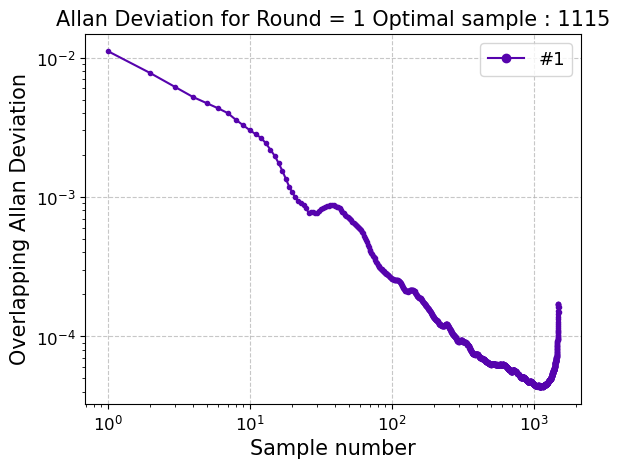

The optimal averaging time 1267.0
List of optimal time [1115, 1419]


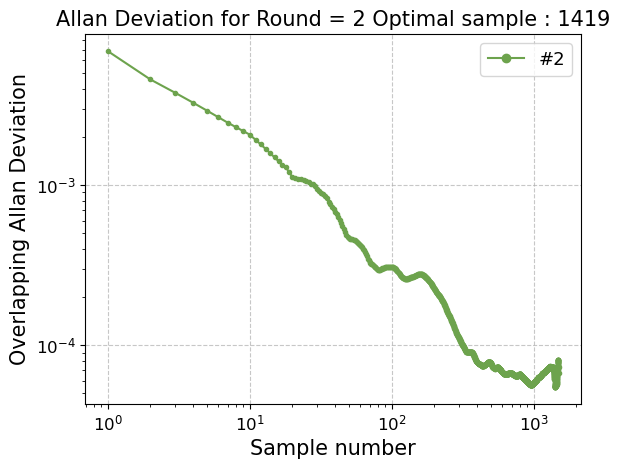

The optimal averaging time 1185.0
List of optimal time [1115, 1419, 1021]


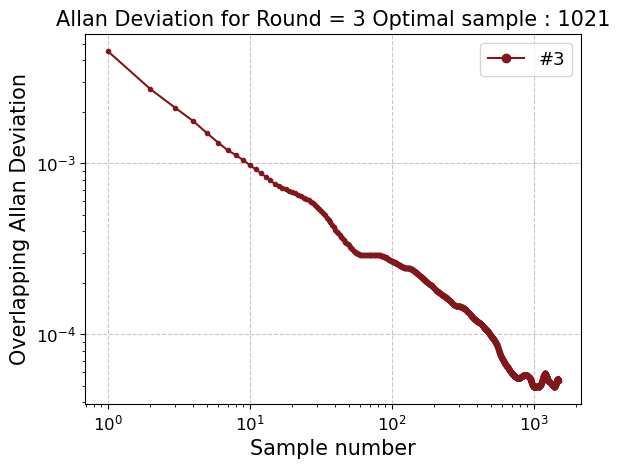

In [5]:
"""
PLOTTING THE ALLAN DEVIATION
"""
def plotallan(plt, y, rate, taus, label, color):
    t2, ad, _, _ = allantools.oadev(y, rate=rate, data_type="phase", taus=taus)
    plt.loglog(t2, ad, color=color, marker=".", label=label)
    return t2, ad

x_min_list = []
colors = ["#5603AD", "#6DA34D", "#81171B", "#F19C79", "#F77F00", "#2274A5"]
taus = np.arange(0, 3001)
for index, file in enumerate(filenames):
    label=f"#{index+1}"
    x_data, y_data = plotallan(plt, np.array(theta_mle[file]), 1, taus , label, color=colors[index])

    y_min = np.min(y_data)
    x_min = list(y_data).index(y_min)
    
    x_min_list.append(x_min)

    x_min_average = np.average(np.array(x_min_list))
    print(f"The optimal averaging time {x_min_average}")
    print(f"List of optimal time {x_min_list}")

    plt.xlabel(r'Sample number', fontsize=15)
    plt.ylabel('Overlapping Allan Deviation', fontsize=15)
    plt.legend(fontsize=13, markerscale=2.)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f"Allan Deviation for Round = {index+1} Optimal sample : {x_min_list[index]}", fontsize=15)
    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Bell\Long_QPE_no_Certification\Allan_Deviation_Graph\Allan_deviation_r={index+1}_Bottom")

    plt.show()

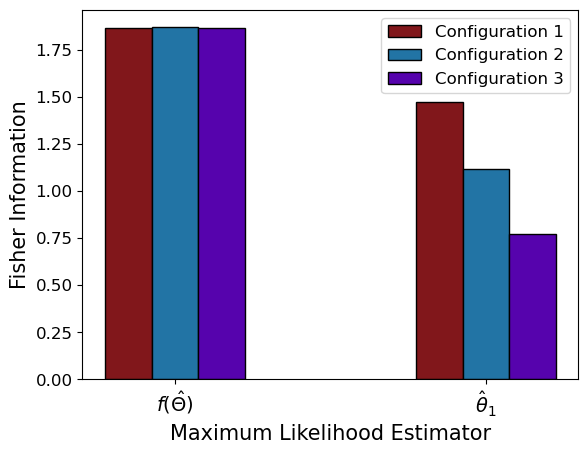

In [12]:
"""
PLOTTING THE FISHER INFORMATION FOR THE EACH OF THE a_vectors DEFINED ABOVE
"""
def plot_histogram(data, labels, colors, bar_width=0.15, ylim=None):
    num_groups = len(data[0])  # Assuming all datasets have the same number of x-axis groups
    num_datasets = len(data)
    x = np.arange(num_groups)  # X-axis positions for the first dataset
    
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    
    for i in range(num_datasets):
        ax.bar(x + i * bar_width, data[i], width=bar_width, label=labels[i], color=colors[i], edgecolor='black')
    
    ax.set_xticks(x + (num_datasets - 1) * bar_width / 2)
    ax.set_xticklabels([r'$f(\hat{\Theta})$', r'$\hat{\theta}_{1}$'], fontsize=14)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Maximum Likelihood Estimator", fontsize = 15)
    ax.set_ylabel("Fisher Information", fontsize = 15)

    # ax.set_title("Histogram with Multiple Data Sets")
    ax.legend(fontsize=12)
    
    if ylim:
        ax.set_ylim(0, ylim)

    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\Long_QPE_no_Certification\Fisher_Information")
    plt.show()

# Example data for 6 datasets, each having values for 5 groups
data = [
    thetas_mle[0]["dm"]["sum"]["fisher_info"],
    thetas_mle[1]["dm"]["sum"]["fisher_info"],
]

data=np.transpose(data)
labels = ["Configuration 1", "Configuration 2", "Configuration 3"]
colors = ["#81171B", "#2274A5", "#5603AD", "#F19C79", "#F77F00", "#6DA34D"]

plot_histogram(data, labels, colors)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

os.chdir(r'C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\QST\Long_QPE_no_Certification')
folder = [i for i in glob.glob(r"Run*")]



Angles = {'RUN_1' : [np.pi/8,np.pi/5,np.pi/16,0.3534291735288517],'RUN_2' : [np.pi/6,np.pi/4,np.pi/8,-0.13089969389957457],
          'RUN_3' : [2*np.pi/9,np.pi/7,np.pi/8,0.7476646259971648],'RUN_4' : [0,np.pi/6,np.pi/5,0.41887902047863923],
          'RUN_5' : [np.pi/16,np.pi/10,np.pi/12,0.7984881327874058],'RUN_6' : [np.pi/20,np.pi/16,np.pi/19,1.052020171498161]}

def plot_histogram(data, labels, colors, bar_width=0.15, ylim=None):
    num_groups = len(data[0])  # Assuming all datasets have the same number of x-axis groups
    num_datasets = len(data)
    x = np.arange(num_groups)  # X-axis positions for the first dataset
    
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    
    for i in range(num_datasets):
        ax.bar(x + i * bar_width, data[i], width=bar_width, label=labels[i], color=colors[i], edgecolor='black')

    
    legend_added = False  # Variable pour éviter de répéter la légende

    for i in range(num_groups):
            for w in range(num_datasets):
                x_point = x[i] + w * bar_width
                y_point = Angles[str(folder[i])][w] * 180 / np.pi

                if not legend_added:  # Ajouter la légende une seule fois
                    ax.scatter(x_point, y_point, color='red', s=20, marker="x", label='Value to Estimate')
                    legend_added = True
                else:
                    ax.scatter(x_point, y_point, color='red', s=20, marker="x")
            

    ax.set_xticks(x + (num_datasets - 1) * bar_width / 2)
    ax.set_xticklabels(['#1', '#2', '#3', '#4', '#5', '#6'], fontsize=14)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Configuration", fontsize = 15)
    ax.set_ylabel("Estimator Value (°)", fontsize = 15)

    # ax.set_title("Histogram with Multiple Data Sets")
    ax.legend(fontsize=12, bbox_to_anchor=(1, 1))

    
    if ylim:
        ax.set_ylim(-180, ylim)

    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\Long_QPE_no_Certification\Estimator_Value.pdf")
    plt.show()

# Example data for 6 datasets, each having values for 5 groups
data = [
    thetas_mle["dm"]["indiv"]["values"][0]*180/np.pi,
    thetas_mle["dm"]["indiv"]["values"][1]*180/np.pi,
    thetas_mle["dm"]["indiv"]["values"][2]*180/np.pi,
    thetas_mle["dm"]["indiv"]["values"][3]*180/np.pi
]

# data=np.transpose(data)
labels = [r"$\hat{\theta}_1$", r"$\hat{\theta}_2$", r"$\hat{\theta}_3$", r"$\hat{\theta}_4$"]
colors = ["#81171B", "#2274A5", "#5603AD", "#F77F00", "#6DA34D"]

plot_histogram(data, labels, colors, ylim=200)

In [8]:
"""
TEST OF THE DENSITY MATRIX WITH PERFECT STATES
"""
# import random
# sampleList = np.identity(16)
# These are the weigths for each outcome, given two perfect Bell states
# randomList = random.choices(sampleList, weights=(0.18213835, 0.03125   , 0.03125   , 0.18213835, 0.03125   ,
#                                                 0.00536165, 0.00536165, 0.03125   , 0.03125   , 0.00536165,
#                                                 0.00536165, 0.03125   , 0.18213835, 0.03125   , 0.03125   ,
#                                                 0.18213835), k=10000)
mle = {}
thetas_mle = {"0" :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}},
              "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}}},
            "1" :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}},
              "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((2,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((2,3))}}}}

def generate_angles_in_radians(n):
    x = []
    """
    Génère 4 angles aléatoires en radians, chacun étant compris entre 0 et π/2,
    et dont la somme est exactement égale à π/2.
    """
    for i in range(n):
        target_sum = np.pi / 2  # Somme cible
        angles = np.sort(np.random.uniform(0, target_sum, 1))  # Générer 3 points de coupure aléatoires
        
        # Calculer les 4 angles en prenant les différences successives
        a1 = angles[0]
        a4 = target_sum - angles[0]  # Assurer que la somme soit bien égale à π/2

        x.append([a1, a4])

    return x


def set_estimation_params(estimator_class, dic, index, a_vectors_list):
    mle = estimator_class
    estimation_results = mle.get_theta(get_cov = True, set_lim = None).x

    dic["sum"]["values"][index] = np.array(np.sum(estimation_results))
    dic["sum"]["variance"][index] = np.array(mle.get_variance(np.array([1, 1])))
    dic["sum"]["fisher_info"][index] = np.array(mle.fisher_bound/n_rounds)
    for i in range(2):
        dic["indiv"]["values"][i][index] = (estimation_results[i])
        dic["indiv"]["variance"][i][index] = np.array(mle.get_variance(a_vectors_list[i]))
        dic["indiv"]["fisher_info"][i][index] = np.array(mle.fisher_bound/n_rounds)
    return dic

### Vector list to extract the estimation of the indifivual params
a_vectors_list = [np.array([1, 0]), np.array([0, 1])]

# ghz = (np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
# ghzmatrix = np.array(np.outer(ghz, np.conjugate(ghz)))
# state = ghzmatrix

bell = (np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
bellmatrix = np.array(np.outer(bell, np.conjugate(bell)))
state = np.kron(bellmatrix, bellmatrix)

# plus = (np.array([1,0])+np.array([0,1]))/np.sqrt(2)
# plusmatrix = np.array(np.outer(plus, np.conjugate(plus)))
# state = np.kron(np.kron(np.kron(plusmatrix, plusmatrix), plusmatrix), plusmatrix)

x0 = generate_angles_in_radians(1)
state = 'Bell'
qubit = ['0','1']
for index, file in enumerate(filenames):
    for i in range(len(counts_name)):
        v = 1 #- 2*final_p_fail_mean[index]
        dm = bellmatrix
        meas_stats = stats_lists[index][i]
        ##### Theta estimation and saving params in dictionary #####
        #np.array([np.pi/8, np.pi/8, np.pi/8, np.pi/8])#-np.pi/8-np.pi/5-np.pi/16])
        bnds = ((0,np.pi/2),(0,np.pi/2))
        mle[file] = qpe.Estimator(state,qubit[i],meas_stats, x0,bnds, "visibility", v)
        set_estimation_params(mle[file], thetas_mle[f'{i}']["v"], index, a_vectors_list)
        mle[file].set_function_type("density_matrix", dm)
        set_estimation_params(mle[file], thetas_mle[f'{i}']["dm"], index, a_vectors_list)

c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:78: RuntimeWarning: divide by zero encountered in log
  prob_distribution -= np.log((1 - (-1)**outcome * v * np.cos(np.sum(x))) / 2)
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:147: RuntimeWarning: divide by zero encountered in log
  prob_distribution -= np.log(np.real(outcome@meas_dm@outcome))
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:78: RuntimeWarning: divide by zero encountered in log
  prob_distribution -= np.log((1 - (-1)**outcome * v * np.cos(np.sum(x))) / 2)
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:147: RuntimeWarning: divide by zero encountered in log
  pr

In [9]:
print(thetas_mle["0"]["dm"]["sum"]["values"]*180/np.pi)
print(thetas_mle["1"]["dm"]["sum"]["values"]*180/np.pi)

[21.25141373 17.94851944 27.37717792]
[62.52729279 69.8382958  57.04381733]


In [10]:
print(thetas_mle["0"]["v"]["sum"]["values"]*180/np.pi)
print(thetas_mle["1"]["v"]["sum"]["values"]*180/np.pi)

[21.25134144 17.94833659 27.37720163]
[62.52694476 69.83792008 57.04384236]


In [ ]:
# # Data for Allan Deviation
# x_optimal = 975
# x_min_list [849, 828, 1096, 1123, 969, 983]

# # Data for GHZ:
# # for the global parameter estimation
# # The different elements of the array represent the different configurations
# theta_sum_mle_all_v = np.array([85.51043935, 81.75564343, 88.74673478, 85.1647397 , 81.67627524, 85.88318997])
# theta_sum_mle_var_all_v = np.array([1.86743408, 1.87335425, 1.86326839, 1.86193299, 1.86385631, 1.86150072])
# theta_sum_mle_all_dm = np.array([87.17989025, 83.88837764, 90.68823052, 89.6194445 , 82.81762194, 93.15648155])
# theta_sum_mle_var_all_dm = np.array([2.00013213, 1.97082046, 1.9721261 , 1.98259703, 1.97717742, 1.96419995])
# theta_sum_mle_fisher_all_dm = np.array([3282.37265094, 3380.73499917, 3376.26007708, 3340.69134786, 3359.03068031, 3403.56354657])
# theta_sum_mle_fisher_all_v = np.array([3765.43089215, 3741.66935505, 3782.2864881 , 3787.71401994, 3779.90019221, 3789.47313677])

# For the individual thetas
# Each array is [n]x[m] where n is the individual index and m is the configuration
# thetas_mle_dm = np.array([[ 1.09964826,  1.09964826,  1.09964826,  1.09964826,  1.09964826, 1.09964826],
#                           [-2.02412179, -2.02412179, -2.02412179, -2.02412179, -2.02412179, -2.02412179],
#                           [ 0.38935297,  0.38935297,  0.38935297,  0.38935297,  0.38935297, 0.38935297],
#                           [ 2.16100788,  2.16100788,  2.16100788,  2.16100788,  2.16100788, 2.16100788]])
# vars_mle_dm = np.array([[0.03381926, 0.03381926, 0.03381926, 0.03381926, 0.03381926, 0.03381926],
#                         [0.03403578, 0.03403578, 0.03403578, 0.03403578, 0.03403578, 0.03403578],
#                         [0.03393289, 0.03393289, 0.03393289, 0.03393289, 0.03393289, 0.03393289],
#                         [0.03532381, 0.03532381, 0.03532381, 0.03532381, 0.03532381, 0.03532381]])
# fishers_mle_dm = np.array([[874.32289579, 874.32289579, 874.32289579, 874.32289579, 874.32289579, 874.32289579],
#                            [863.23431838, 863.23431838, 863.23431838, 863.23431838, 863.23431838, 863.23431838],
#                            [868.47699341, 868.47699341, 868.47699341, 868.47699341, 868.47699341, 868.47699341],
#                            [801.42867191, 801.42867191, 801.42867191, 801.42867191, 801.42867191, 801.42867191]])

In [ ]:
############## Estimation with the maximum likelihood estimator #################
############## Saves the evolution of the estimation ##################
# n_samples = {}
# theta_mle = {}
# theta_mle_error = {}
# hessian_matrix = {}
# fisher_info = {}
# var = {}

# def sum_min_bound(x):
#     return np.sum(x)

# def sum_up_bound(x):
#     return np.pi-np.sum(x)
    
# cons = [{'type': 'ineq', 'fun': sum_min_bound},
#         {'type': 'ineq', 'fun': sum_up_bound}]

# for index, file in enumerate(filenames):
#     n_samples_evol = []
#     theta_mle_evol = []
#     theta_mle_error_evol = []
#     hessian_matrix_evol = []
#     fisher_info_evol = []
#     var_evol = []
    
#     print(f"Estimating data for {file}")
#     v = 1 - final_p_fail_mean[index]

#     ### Setting array with measurement results of each sensing rounds. Results are either 0 (odd) or 1 (even)
#     meas_results = np.sum((stats_list[index].counts_array*(stats_list[index].eigenvalues + 1)/2), axis = 1)

#     for j in range(3001):
#         ### Setting array with measurement results of each sensing rounds. Results are either 0 (odd) or 1 (even)
#         meas_results_cap = meas_results[:j]
#         ##### Theta estimation #####
#         x0 = np.array([np.pi/8, np.pi/8, np.pi/8, np.pi/8])
        
#         constraints = cons
#         mle = sp.minimize(qpe.likelihood_function,
#                         x0,
#                         args = (v, meas_results_cap),
#                         method = 'SLSQP',
#                         constraints = cons)
#         theta_mle_evol.append(np.sum(mle.x))
#         n_samples_evol.append(j)
        
#         # # # ### Setting the frequency of ech measurement result
#         # f_x0 = stats_list[index].N_pass
#         # f_x1 = stats_list[index].N_fail
        
#         # # ### Getting the variancce from a specific python package
#         # hessian_func = nd.Hessian(qpe.likelihood_function)  # Create a Hessian function
#         # hessian_scipy = hessian_func(mle.x, v, meas_results)  # Evaluate the Hessian

#         # a_vector = np.array([1, 1, 1, 1])
#         # a_vector_norm = np.array([1, 1, 1, 1])/np.linalg.norm(a_vector)

#         # fisher_bound = a_vector_norm@hessian_scipy@a_vector_norm
#         # var2_norm = 1/fisher_bound
#         # var2 = (np.linalg.norm(a_vector)**2)*var2_norm
#         # var_value = np.sqrt(var2)

#         # hessian_matrix_evol.append(hessian_scipy)
#         # fisher_info_evol.append(fisher_bound)
#         # var_evol.append(var_value)

#     theta_mle[file] = np.array(theta_mle_evol)
#     # hessian_matrix[file] = np.array(hessian_matrix_evol)
#     # fisher_info[file] = np.array(fisher_info_evol)
#     # var[file] = np.array(var_evol)
#     n_samples[file] = np.array(n_samples_evol)

#     # writting_dir = f"{data_dir}\{file}\estimation_stats"
#     # os.makedirs(f"{writting_dir}", exist_ok=True)

#     # f = open(f"{writting_dir}\\theta_mle.txt", "w")
#     # f.write(str(theta_mle_evol)) 
#     # f.close()

#     # # f = open(f"{writting_dir}\\hessian_matrix.txt", "w")
#     # # f.write(str(hessian_matrix_evol)) 
#     # # f.close()

#     # # f = open(f"{writting_dir}\\fisher_info.txt", "w")
#     # # f.write(str(fisher_info_evol)) 
#     # # f.close()

#     # # f = open(f"{writting_dir}\\var.txt", "w")
#     # # f.write(str(var_evol)) 
#     # # f.close()

#     # f = open(f"{writting_dir}\\n_samples.txt", "w")
#     # f.write(str(n_samples_evol)) 
#     # f.close()

In [ ]:


# def Maximun_Likelihood(Y:float,V:float,N:int,X):
    
#     '''-
#     Function to calculate the maximun likelihood function of the parity distribution
#     Y : The linear fucntion of thetas
#     V : The visibility
#     N : The number of measurment (Here the number of qubits)
#     X : The measurement result. 
#     '''

#     Dis_prob = (1 + V*np.cos(N*Y-X*np.pi))/(2)
#     return(-np.sum(np.log(Dis_prob)))

# def plotallan(plt, y, rate, taus, style, label, color):
#     t2, ad, _, _ = allantools.oadev(y, rate=rate, data_type="phase", taus=taus)
#     plt.loglog(t2, ad, style, color=color, marker=".", label=label)

# theta_mle_all = []
# N = 4

# for index, file in enumerate(filenames):

#     meas_results = np.sum((stats_list[index].counts_array*(stats_list[index].eigenvalues + 1)/2), axis = 1)
#     v = 1 - final_p_fail_mean[index]
#     theta_mle_list = []

#     for z in range(len(meas_results)):
#     ### Setting array with measurement results of each sensing rounds. Results are either 0 (odd) or 1 (even)
#     ##### Theta estimation #####
#         x0 = np.array([np.pi/8, np.pi/8, np.pi/8, np.pi/8])
#         mle = sp.minimize(qpe.likelihood_function,
#                             x0,
#                             args = (v, meas_results),
#                             method = 'BFGS')
#         theta_mle_list.append(np.sum(mle.x))
    
#     theta_mle_all.append(theta_mle_list)

# colors = ["#5603AD", "#6DA34D", "#81171B", "#F19C79", "#F77F00", "#2274A5"]

# for index, file in enumerate(filenames):
#     label=f"#{index+1}"
#     plotallan(plt, np.array(theta_mle_all[index]), 0.84, "all" , 'b.', label, color=colors[index])

# plt.xlabel('Number of Sensing Rounds', fontsize=15)
# plt.ylabel('Overlapping Allan Deviation', fontsize=15)
# plt.legend(fontsize=13, markerscale=2.)
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.savefig(rf"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\Figures\QPE\{input_state}\long_sensing_Allan_all_rounds_theta", dpi=300)
# plt.show()

In [ ]:
# ############## Estimation with the inversion of the likelihood function #################
# theta_inverse_list = []
# theta_inv_error_list = []

# hessian_matrix_list = []
# fisher_info_list = []

# x_data = [1, 2, 3, 4, 5, 6]

# for index, file in enumerate(filenames):
#     v = 1 - final_p_fail_mean[index]

#     # Compute inverse probability
#     theta_inverse, theta_inv_error = qpe.get_theta(p_pass[index][-1], v, p_pass_error[index][-1], final_p_fail_error_mean[index])
#     theta_inverse_list.append(theta_inverse)
#     theta_inv_error_list.append(theta_inv_error)

# theta_inverse_all = np.array(theta_inverse_list, dtype = float)

# theta_inv_error_all = np.array(theta_inv_error_list, dtype = float)
# theta_mean = np.average(theta_inverse_all)

# # Plot results
# plt.errorbar(x_data, theta_inverse_all*180/np.pi, theta_inv_error_all*180/np.pi, label="Theta inv", marker='o', linestyle="")

# # plt.axhline(theta_mean*180/np.pi, color='blue', linestyle='--', label=f"Mean theta ({180/np.pi*theta_mean:.2f}°)")
# plt.axhline(np.pi/2*180/np.pi, color='red', linestyle='-', label=f"Target theta")


# plt.xlabel("Round")
# plt.ylabel("Theta (°)")
# plt.ylim(0, 105)
# plt.title("Parameter Estimation")
# plt.legend()
# plt.grid(True)
# plt.show()